In [1]:
import math
import numpy as np
from tqdm import tqdm
import torch
import pickle

from helpers.data import get_pdf_toy, read_in_data
from helpers.ansatz import q, get_factorial_cache, get_taylor_expanded_ansatz
import matplotlib.pyplot as plt
from rikabplotlib.plot_utils import newplot, hist_with_errors, hist_with_errors

import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import pickle


In [2]:
device = "cpu"

In [3]:
outfile_name = f"thrust_2_rikab_test"

save_dict = {}
is_final_string = ""

with open(f"output" + is_final_string + f"/{outfile_name}_config", "rb") as ifile:
    save_dict["configs"] = pickle.load(ifile)

losses = np.load(f"output" + is_final_string + f"/{outfile_name}_losses.npy")
g_coeffs_log = np.load(f"output" + is_final_string + f"/{outfile_name}_g_coeffs.npy")
theta_log = np.load(f"output" + is_final_string + f"/{outfile_name}_theta.npy")


distribution = save_dict["configs"]["distribution"]
order_to_match = save_dict["configs"]["order_to_match"]
name = save_dict["configs"]["name"]
mstar = save_dict["configs"]["mstar"]
run_toy = save_dict["configs"]["run_toy"]

print(save_dict["configs"])


print(distribution)
print(save_dict["configs"])

titles = {
    "thrust" : r"Thrust @ " + r"$\mathcal{O}(\alpha_s^" + str(1) + "$)\t\t\t\t\t",
    "LO_thrust" : r"Thrust @ " + r"$\mathcal{O}(\alpha_s^" + str(1) + "$)\t\t\t\t\t",
          "angularity" : r"Pseudo-Angularity @ " + r"$\mathcal{O}(\alpha_s^" + str(2) + "$)\t\t\t\t\t",
        }

ylims = {"LO_thrust" : (-1.5, 1.1),
          "thrust" : (-1.5, 1.1),
          "angularity" : (-0.5, 1.1),
}

xlabels_t  = {"LO_thrust" : r"$t = \log(1/\tau)$",
               "thrust" : r"$t = \log(1/\tau)$",
               "angularity" : r"$t = \log(1/\lambda)$",
              }

order_colors = {1 : "blue", 2 : "purple", 3 : "red"}





{'distribution': 'thrust', 'run_toy': False, 'order_to_match': 2, 'name': 'rikab_test', 'mstar': 1, 'init_random': True, 'init_g_matrix_path': 'thrust_2_rikab_test', 'init_theta_path': 'thrust_2_rikab_test', 'learn_theta': True, 'reroll_initialization': False, 'ratio_loss': False, 'weighted_mse_loss': True, 'use_logbins': False, 'n_bins': 200, 't_min': 0, 't_max': 10, 'epochs': 5000, 'batch_size': 320, 'lr': 0.001, 'seed': 42, 'weight_decay': 0.001, 'm': 2, 'n': 8, 'device': 'cpu'}
thrust
{'distribution': 'thrust', 'run_toy': False, 'order_to_match': 2, 'name': 'rikab_test', 'mstar': 1, 'init_random': True, 'init_g_matrix_path': 'thrust_2_rikab_test', 'init_theta_path': 'thrust_2_rikab_test', 'learn_theta': True, 'reroll_initialization': False, 'ratio_loss': False, 'weighted_mse_loss': True, 'use_logbins': False, 'n_bins': 200, 't_min': 0, 't_max': 10, 'epochs': 5000, 'batch_size': 320, 'lr': 0.001, 'seed': 42, 'weight_decay': 0.001, 'm': 2, 'n': 8, 'device': 'cpu'}


In [4]:
# Helper functions ofr plotting

max_M, max_N = g_coeffs_log[0].shape


factorial_cache_n = torch.tensor([math.factorial(k) for k in range(max_N)], device=device).float()
factorial_cache_m = torch.tensor([math.factorial(k) for k in range(max_M)], device=device).float()
n_range = torch.arange(max_N, device=device)
m_range = torch.arange(1, max_M, device=device)

factorial_cache_info = factorial_cache_m, factorial_cache_n, m_range, n_range



In [5]:
def build_title(ax):

    # Get the observable name
    titles = {
    "thrust" : r"Thrust",# + r"$\mathcal{O}(\alpha_s^" + str(1) + "$)\t\t\t\t\t",
    "c_param" : r"C-Parameter",# + r"$\mathcal{O}(\alpha_s^" + str(1) + "$)\t\t\t\t\t",
    "angularity" : r"Rayleigh",# + r"$\mathcal{O}(\alpha_s^" + str(2) + "$)\t\t\t\t\t",
    "rayleigh" : r"Rayleigh", # + r"$\mathcal{O}(\alpha_s^" + str(2) + "$)\t\t\t\t\t",
    "exponential" : r"Exponential", # + r"$\mathcal{O}(\alpha_s^" + str(2) + "$)\t\t\t\t\t",
        }
    
    for key in titles:
        if key in outfile_name:
            title = titles[key]
            break

    # Get the order
    order_string = r" @ $\mathcal{O}(\alpha_s^" + str(order_to_match) + r"$)"

    if run_toy:
        order_string += r" [Toy]"
    else:
        order_string += r" [EERAD3v2]"

    ax.set_title(title + order_string, loc = "right")

    return ax

<Axes: title={'right': 'Thrust @ $\\mathcal{O}(\\alpha_s^2$) [EERAD3v2]'}, xlabel='Epoch', ylabel='Loss'>

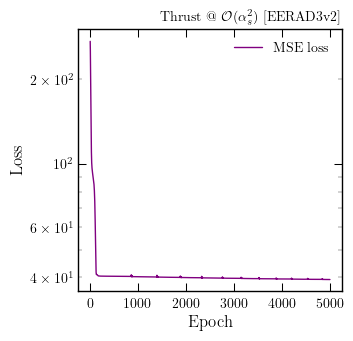

In [6]:


# Plot loss
fig, ax = newplot("column")

plt.plot(losses, label="MSE loss", color = order_colors[order_to_match])
plt.legend()
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")

build_title(ax)



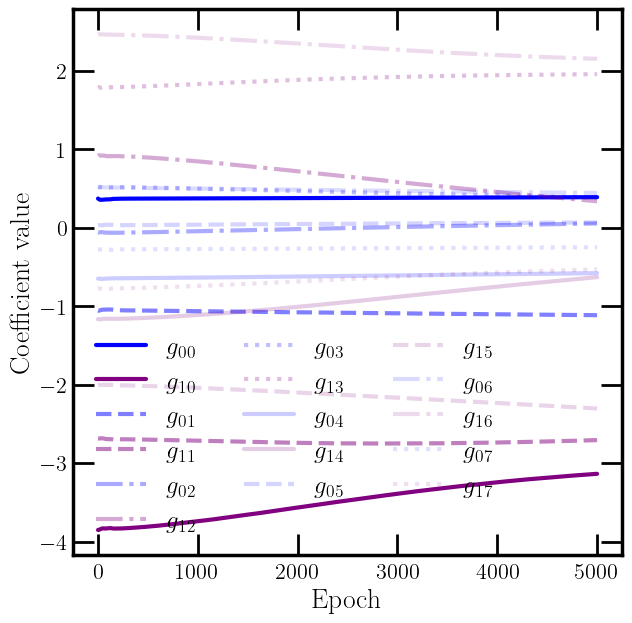

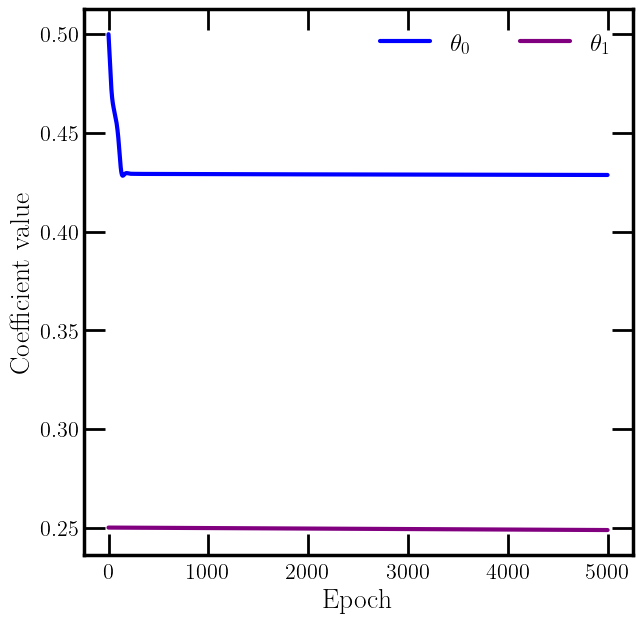

In [7]:


from matplotlib.pyplot import cm
# color = iter(cm.hsv(np.linspace(0, 1, g_coeffs_log.shape[2]+1)))
opacities = [1 / (n+1) for n in range(g_coeffs_log.shape[2])]
linestyles = ["-", "--", "-.", ":", ]

# colors = ["red", "orange", "gold"]

fig, ax = newplot('full')
for n in range(g_coeffs_log.shape[2]):
    for m in range(g_coeffs_log.shape[1]):
        label = f"$g_{{{m}{n}}}$"
        c = order_colors[m+1]
        l = linestyles[n % len(linestyles)]
        plt.plot(g_coeffs_log[:, m, n], label=label, color=c, alpha=opacities[n], linestyle=l)
plt.legend(ncol = 3)#, title = "Thrust @ " + r"$\mathcal{O}(\alpha_s^" + str(order_to_match) + "$)\t\t\t\t\t")
plt.xlabel("Epoch")
plt.ylabel("Coefficient value")
# plt.ylim(ylims[distribution])
plt.savefig(f"figures/{outfile_name}_coeffs_nice.png", bbox_inches = "tight")

plt.show()


# thetas

fig, ax = newplot('full')
for n in range(theta_log.shape[1]):
    label = f"$\\theta_{{{n}}}$"
    c = order_colors[n+1]
    plt.plot(theta_log[:, n], label=label, color=c)
plt.legend(ncol = 3)#, title = "Thrust @ " + r"$\mathcal{O}(\alpha_s^" + str(order_to_match) + "$)\t\t\t\t\t")
plt.xlabel("Epoch")
plt.ylabel("Coefficient value")
# plt.ylim(ylims[distribution])
plt.savefig(f"figures/{outfile_name}_thetas_nice.png", bbox_inches = "tight")   


In [8]:

with open(f"data/pythia_distribution.pkl", "rb") as ifile:
    pythia_data = pickle.load(ifile)
    
    
    key = "thrusts" if "thrust" in outfile_name else "c_parameterss"
    pythia_data = pythia_data["thrusts"]

    if key == "thrusts":
        pythia_data *= 2


[0.01087598 0.6037967  0.03104284 ... 0.00936122 0.12492208 0.44703343]


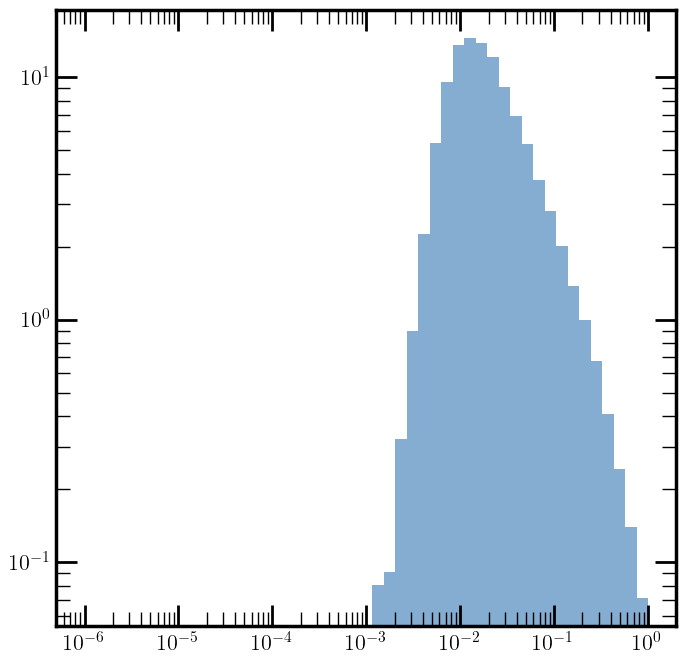

In [9]:

print(pythia_data * 2)
bins = np.logspace(-6, 0, 50)
plt.hist(pythia_data * 2, bins=bins, density=True, label="Pythia 8.306", alpha=0.5)
plt.yscale("log")
plt.xscale("log")


In [10]:



if save_dict["configs"]["use_logbins"]:
    t_bins = torch.logspace(
        np.log10(save_dict["configs"]["t_min"]), np.log10(save_dict["configs"]["t_max"]), save_dict["configs"]["n_bins"], device=device
    )
    t_bin_centers = torch.sqrt((t_bins[1:] * t_bins[:-1]))
else:
    t_bins = torch.linspace(save_dict["configs"]["t_min"], save_dict["configs"]["t_max"], save_dict["configs"]["n_bins"], device=device)
    t_bin_centers = 0.5 * (t_bins[1:] + t_bins[:-1])
   

if not run_toy:  # only needs to be done once
    data_dict,t_bins,t_bin_centers = read_in_data(distribution, order_to_match, device)
    data_dict_XSPACE,x_bins,x_bin_centers = read_in_data(distribution, order_to_match, device, space="x")
t_min = torch.min(t_bins)
t_max = torch.max(t_bins)
        
print(save_dict["configs"]["use_logbins"])
print(t_bin_centers.shape, t_bins.shape)

tt = torch.linspace(save_dict["configs"]["t_min"], save_dict["configs"]["t_max"], 200, device=device)


colors = ["red", "purple", "blue", "green"]


False
torch.Size([200]) torch.Size([201])


[[0.42867157]
 [0.24875312]]
tensor(-1.0000, dtype=torch.float64)
tensor(-1.0000, dtype=torch.float64)
tensor(-0.9997, dtype=torch.float64)


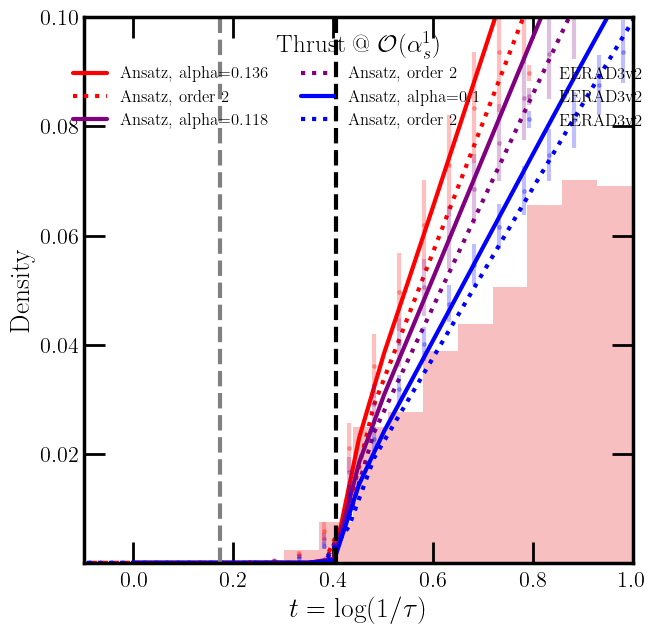

In [11]:

fig, ax = newplot("full")
# theta_log[-1, 1] = 0.75
# theta_log[-1, 0] = 0.16

print(theta_log[-1])
    
for i, alpha in enumerate([0.136, 0.118, 0.1]):
    alpha_tensor = torch.tensor(alpha, device=device)

    # plot ansatz
    plt.plot(tt.detach().cpu().numpy(),q(tt, alpha_tensor, torch.tensor(g_coeffs_log[-1], device=device), 
                                         torch.tensor(theta_log[-1], device=device), mstar, device).detach().cpu().numpy(),
             label=f"Ansatz, alpha={alpha}",color=colors[i],)


      # plot ansatz derivative
    alpha_zero = torch.tensor(1e-12, device=device, requires_grad=True)
    fn = lambda a: q(
        t_bin_centers, a,  torch.tensor(g_coeffs_log[-1], device=device),  torch.tensor(theta_log[-1], device=device), mstar, device
    )
    batch_ansatz = get_taylor_expanded_ansatz(fn, alpha_zero, alpha_tensor, order_to_match)


    plt.plot(t_bin_centers.detach().cpu().numpy(),batch_ansatz.detach().cpu().numpy(),label=f"Ansatz, order {order_to_match}",color=colors[i],linestyle="dotted")



    
    if run_toy:
        # plot all-orders solution
        plt.plot(t_bin_centers.detach().cpu().numpy(),get_pdf_toy( alpha_tensor, distribution, t_bin_centers, -1, device).detach() .cpu().numpy(), label="Target (exact)",color=colors[i],linestyle="dashed",)
        # plot-fixed order target
        plt.scatter(  t_bin_centers.detach().cpu().numpy(),get_pdf_toy( alpha_tensor, distribution, t_bin_centers, order_to_match,  device ).detach().cpu()  .numpy(),label=f"Target (order $\\alpha^{order_to_match}$)",color=colors[i],s=0.8,)

    else:
        # plot histogram
        keys = np.array(list(data_dict.keys()))
        closest_alpha = keys[np.argmin(np.abs(keys - alpha))]
        loc_data, loc_err = data_dict[closest_alpha]
        plt.errorbar(t_bin_centers.detach().cpu().numpy(), loc_data.detach().cpu().numpy().reshape(-1,), yerr=loc_err.detach().cpu().numpy().reshape(-1,),  label="EERAD3v2",  color=colors[i], fmt = "o", alpha = 0.25,)

    # print integral
    print(torch.trapz(q(t_bin_centers, alpha_tensor, torch.tensor(g_coeffs_log[-1], device=device), torch.tensor(theta_log[-1], device=device), mstar, device), t_bin_centers))

plt.hist(np.log(1 / (pythia_data)), density=True, bins=100, alpha=0.5, color = "lightcoral")



def helper_theta(x, x0, temperature=250):
    #return torch.where(x >= 0, 1.0, 0.0)
    return torch.sigmoid(temperature * (x - x0))


plt.axvline(np.log(1/0.666), color="black", linestyle="dashed")
plt.axvline(np.log(1/0.84), color="grey", linestyle="dashed")


# plt.plot(tt.detach().cpu().numpy(), 0.1 * helper_theta(tt, theta_log[-1][0]), label=f"Helper Theta (alpha={alpha})", color=colors[i], linestyle="dashed")

# shade in after t = 7
# plt.axvspan(7, 10, color="lightgray", alpha=0.5)
# plt.text(8.5, 0.0001, "IR cuts", fontsize=16, color="black", ha="center", va="center", rotation=0)
# plt.text(2.5, 0.0001, "Pythia 8.3", fontsize=16, color="red", ha="center", va="center", rotation=0)

plt.axhline(0, color="black", linewidth=1.0)
plt.legend(loc = "upper center", ncol = 3, fontsize = 12, title = titles[distribution])
plt.xlabel(r"$t = \log(1/2\tau)$")
plt.ylabel("Density")
plt.xlim(-0.1, 1)
plt.ylim(1e-5, 2)

plt.xlim(-0.1, 1)
plt.ylim(1e-5, 1e-1)
plt.xlabel(xlabels_t[distribution])
# plt.yscale("log")
plt.savefig(f"figures/{outfile_name}_results_nice.png", bbox_inches = "tight")

plt.show()

In [12]:
i





# if save_dict["configs"]["use_logbins"]:
#     print("Using log bins")
#     t_bins = torch.logspace(
#         np.log10(save_dict["configs"]["t_min"]), np.log10(save_dict["configs"]["t_max"]), save_dict["configs"]["n_bins"], device=device
#     )
#     t_bin_centers = torch.sqrt((t_bins[1:] * t_bins[:-1]))
# else:
#     t_bins = torch.lnspace(save_dict["configs"]["t_min"], 2 * save_dict["configs"]["t_max"], save_dict["configs"]["n_bins"], device=device)
#     t_bin_centers = 0.5 * (t_bins[1:] + t_bins[:-1])


# if not run_toy:  # only needs to be done once
#     data_dict = read_in_data([2], distribution, t_bins, device)
#     #print(data_dict.keys())



# tt = torch.linspace(save_dict["configs"]["t_min"], 2 * save_dict["configs"]["t_max"], 200, device=device)


# colors = ["red", "purple", "blue"]


# fig, ax = newplot("full")


# alphas = [0.117, 0.052, 0.024]  # Corresponding to the three g_coeffs_log sets
# if run_toy:
#     alphas = [0.150, 0.100, 0.050]


# for i, alpha in enumerate(alphas):
#     alpha_tensor = torch.tensor(alpha, device=device)
#     plt.scatter( 100, 100, label=f"$\\alpha$ = {alpha}",  color=colors[i])



#     plt.plot(  
#        tt.detach().cpu().numpy(),q(tt, alpha_tensor, torch.tensor(g_coeffs_log[-1]).to(device), torch.tensor(theta_log[-1]).to(device), save_dict["configs"]["mstar"], save_dict["configs"]["t_min"], save_dict["configs"]["t_max"], device, factorial_cache_info), label="Ansatz",  color=colors[i],
#     )

#     if run_toy:
#         plt.plot(
#             t_bin_centers.detach().cpu().numpy(),
#             get_pdf_toy( alpha_tensor, distribution, t_bin_centers, -1, device).detach().cpu().numpy(), label="Leading Log", color=colors[i],  linestyle="dashed",
#         )
#         plt.scatter(
#             t_bin_centers.detach().cpu().numpy(),get_pdf_toy(alpha_tensor, distribution, t_bin_centers,order_to_match,device) .detach().cpu() .numpy(),  color="white",  s=10, 
#         )
#         plt.scatter(
#             t_bin_centers.detach().cpu().numpy(),get_pdf_toy(alpha_tensor, distribution, t_bin_centers,order_to_match,device) .detach().cpu() .numpy(), label=f"Target order $\\alpha^{order_to_match}$",  color=colors[i],  s=10, alpha = 0.35
#         )

#     else:
#         alpha_string = "alpha_" + str(int(1000 * alpha)).zfill(4)
#         plt.plot(t_bin_centers.detach().cpu().numpy(),data_dict[alpha_string].detach().cpu().numpy(),label="Target (MG5)",color=colors[i], linestyle="dotted",)
#         # plt.plot(tt.detach().cpu().numpy(),get_pdf_toy(alpha_tensor, "thrust_TEST", tt, -1, device).detach() .cpu().numpy(),label="Leading Log", color=colors[i],linestyle="dashed",
#         # )


#         def LL(tt, alpha_tensor):

#             t = tt.detach().cpu().numpy()
#             alpha = alpha_tensor.detach().cpu().numpy()

#             term_0 = alpha * 4/3 / np.pi
#             term_1 = 4*t-3
#             term_2 = np.exp((-4*t*2/ 2 + 3*t ) * term_0)
#             return term_0 * term_1 * term_2
        
#         # ys = LL(tt, alpha_tensor).astype(np.float32)
#         # plt.plot(tt.detach().cpu().numpy(), ys, label="Leading Log", color=colors[i], linestyle="dashed")   

#         # # Verify that the leading log is normalized
#         # norm = torch.trapz(get_pdf_toy(alpha_tensor, "thrust_TEST", tt, -1, device), tt)
#         # print(f"Leading log norm for alpha {alpha}: {norm.item()}")


# plt.hist(np.log(1 / (2 * pythia_data)), density=True, bins=100, alpha=0.5, color = "lightcoral")

# # shade in after t = 7
# plt.axvspan(7, 10, color="lightgray", alpha=0.5)
# plt.text(8.5, 0.0001, "MG5 IR cuts", fontsize=16, color="black", ha="center", va="center", rotation=0)
# plt.text(2.5, 0.0001, "Pythia 8.3", fontsize=16, color="red", ha="center", va="center", rotation=0)

# plt.axhline(0, color="black", linewidth=1.0)
# plt.legend(loc = "upper center", ncol = 3, fontsize = 12, title = titles[distribution])
# plt.xlabel(r"$t = \log(1/\tau)$")
# plt.ylabel("Density")
# plt.xlim(-0.1, 10)
# plt.ylim(1e-5, 1e2)
# plt.xlabel(xlabels_t[distribution])
# plt.yscale("log")
# plt.savefig(f"figures/{outfile_name}_results_nice.png", bbox_inches = "tight")

# plt.show()

2

In [13]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
with open("event_records_LO_1.pkl", "rb") as ifile:
    data = pickle.load(ifile)
print(data.keys())


#print(data["alpha_0053"]["weight"])



FileNotFoundError: [Errno 2] No such file or directory: 'event_records_LO_1.pkl'

In [ ]:

x_0 = data["alpha_0197"]["c_parameter"]
x_1 = data["alpha_0460"]["c_parameter"]

loc_data_0 = [np.log(1.0 / (x + 1e-12)) for x in x_0]
loc_data_1 = [np.log(1.0 / (x + 1e-12)) for x in x_1]

bins =  np.linspace(0, 10, 20)

bin_width = bins[1] - bins[0]

#loc_data = [np.log(1.0 / ((2*(1-x)) + 1e-12)) for x in x]

plt.figure()


y_0, _ = np.histogram(loc_data_0, weights = data["alpha_0197"]["weight"], bins = bins)
y_1, _ = np.histogram(loc_data_1, weights = data["alpha_0460"]["weight"], bins = bins)

plt.step(bins[1:], y_0/bin_width)
plt.step(bins[1:], y_1/bin_width)

#plt.yscale("log")
plt.show()

In [ ]:

def f_toy(t, alpha):
    pstar =  (6*torch.exp(-y) + (4 / (1 - torch.exp(-y))))*torch.log((1 - 2*torch.exp(-y))/torch.exp(-y)) - 3 + 6*torch.exp(-y) + 9*torch.exp(-2*y)
    return  alpha* (4/3) * pstar / (2*np.pi)


tmin = 0
tmax = 10




t_bins = torch.linspace(tmin, tmax, 100)

qq = q(t_bin_centers, 0.1)


plt.figure()
plt.plot(t_bin_centers.detach().cpu().numpy(), qq.detach().cpu().numpy())
plt.xlabel("t")
plt.show()

In [ ]:
alpha = 0.1

y = alpha* (4/3) * (1.0 / (2*np.pi)) * (4*t_bin_centers - 3)*torch.exp(alpha* (4/3) * (1.0 / (2*np.pi))*(2*torch.pow(t_bin_centers, 2) -3*t_bin_centers))
